In [ ]:
!pip install flask-ngrok

In [ ]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls '/content/gdrive/MyDrive/darknet'

3rdparty	     DarknetConfig.cmake.in  net_cam_v3.sh
appveyor.yml	     darknet.py		     obj
archive		     darknet.pyc	     output.avi
archive_darknet.zip  darknet_video.py	     predictions.jpg
bin		     data		     README.md
build		     get-yolov3_weights.sh   results
build.ps1	     image_yolov2.sh	     scripts
build.sh	     image_yolov3.sh	     src
cfg		     include		     test.mp4
cmake		     json_mjpeg_streams.sh   uselib
CMakeLists.txt	     libdarknet.so	     video_v2.sh
CMakeSettings.json   LICENSE		     video_yolov3.sh
darknet		     Makefile		     yolov3-tiny.weights


In [ ]:
#!cp /content/gdrive/MyDrive/darknet/libdarknet.so ./libdarknet.so
!cp -r /content/gdrive/MyDrive/darknet/ ./

In [ ]:
!ls ./darknet/data

9k.tree        eagle.jpg    horses.jpg		      person.jpg
bouchons.jpeg  eagle.txt    horses.txt		      person.txt
coco9k.map     ferme.jpg    imagenet.labels.list      scream.jpg
coco.names     giraffe.jpg  imagenet.shortnames.list  scream.txt
dog.jpg        giraffe.txt  labels		      table.jpeg
dog.txt        goal.txt     openimages.names	      voc.names


In [ ]:
!cp -r ./darknet/data ./data

Le code suivant permet de faire la détection et de renvoyer sous forme de dictionnaire les prédictions faites

In [ ]:
"""
Python 3 wrapper for identifying objects in images

Requires DLL compilation

Both the GPU and no-GPU version should be compiled; the no-GPU version should be renamed "yolo_cpp_dll_nogpu.dll".

On a GPU system, you can force CPU evaluation by any of:

- Set global variable DARKNET_FORCE_CPU to True
- Set environment variable CUDA_VISIBLE_DEVICES to -1
- Set environment variable "FORCE_CPU" to "true"


To use, either run performDetect() after import, or modify the end of this file.

See the docstring of performDetect() for parameters.

Directly viewing or returning bounding-boxed images requires scikit-image to be installed (`pip install scikit-image`)


Original *nix 2.7: https://github.com/pjreddie/darknet/blob/0f110834f4e18b30d5f101bf8f1724c34b7b83db/python/darknet.py
Windows Python 2.7 version: https://github.com/AlexeyAB/darknet/blob/fc496d52bf22a0bb257300d3c79be9cd80e722cb/build/darknet/x64/darknet.py

@author: Philip Kahn
@date: 20180503
"""
#pylint: disable=R, W0401, W0614, W0703
from ctypes import *
import math
import random
import os
import cv2
import time

def sample(probs):
    s = sum(probs)
    probs = [a/s for a in probs]
    r = random.uniform(0, 1)
    for i in range(len(probs)):
        r = r - probs[i]
        if r <= 0:
            return i
    return len(probs)-1

def c_array(ctype, values):
    arr = (ctype*len(values))()
    arr[:] = values
    return arr

class BOX(Structure):
    _fields_ = [("x", c_float),
                ("y", c_float),
                ("w", c_float),
                ("h", c_float)]

class DETECTION(Structure):
    _fields_ = [("bbox", BOX),
                ("classes", c_int),
                ("prob", POINTER(c_float)),
                ("mask", POINTER(c_float)),
                ("objectness", c_float),
                ("sort_class", c_int)]


class IMAGE(Structure):
    _fields_ = [("w", c_int),
                ("h", c_int),
                ("c", c_int),
                ("data", POINTER(c_float))]

class METADATA(Structure):
    _fields_ = [("classes", c_int),
                ("names", POINTER(c_char_p))]



#lib = CDLL("/home/pjreddie/documents/darknet/libdarknet.so", RTLD_GLOBAL)
#lib = CDLL("libdarknet.so", RTLD_GLOBAL)
hasGPU = True
if os.name == "nt":
    cwd = os.path.dirname(__file__)
    os.environ['PATH'] = cwd + ';' + os.environ['PATH']
    winGPUdll = os.path.join(cwd, "yolo_cpp_dll.dll")
    winNoGPUdll = os.path.join(cwd, "yolo_cpp_dll_nogpu.dll")
    envKeys = list()
    for k, v in os.environ.items():
        envKeys.append(k)
    try:
        try:
            tmp = os.environ["FORCE_CPU"].lower()
            if tmp in ["1", "true", "yes", "on"]:
                raise ValueError("ForceCPU")
            else:
                print("Flag value '"+tmp+"' not forcing CPU mode")
        except KeyError:
            # We never set the flag
            if 'CUDA_VISIBLE_DEVICES' in envKeys:
                if int(os.environ['CUDA_VISIBLE_DEVICES']) < 0:
                    raise ValueError("ForceCPU")
            try:
                global DARKNET_FORCE_CPU
                if DARKNET_FORCE_CPU:
                    raise ValueError("ForceCPU")
            except NameError:
                pass
            # print(os.environ.keys())
            # print("FORCE_CPU flag undefined, proceeding with GPU")
        if not os.path.exists(winGPUdll):
            raise ValueError("NoDLL")
        lib = CDLL(winGPUdll, RTLD_GLOBAL)
    except (KeyError, ValueError):
        hasGPU = False
        if os.path.exists(winNoGPUdll):
            lib = CDLL(winNoGPUdll, RTLD_GLOBAL)
            print("Notice: CPU-only mode")
        else:
            # Try the other way, in case no_gpu was
            # compile but not renamed
            lib = CDLL(winGPUdll, RTLD_GLOBAL)
            print("Environment variables indicated a CPU run, but we didn't find `"+winNoGPUdll+"`. Trying a GPU run anyway.")
else:
    lib = CDLL("./darknet/libdarknet.so", RTLD_GLOBAL)
lib.network_width.argtypes = [c_void_p]
lib.network_width.restype = c_int
lib.network_height.argtypes = [c_void_p]
lib.network_height.restype = c_int

copy_image_from_bytes = lib.copy_image_from_bytes
copy_image_from_bytes.argtypes = [IMAGE,c_char_p]

def network_width(net):
    return lib.network_width(net)

def network_height(net):
    return lib.network_height(net)

predict = lib.network_predict_ptr
predict.argtypes = [c_void_p, POINTER(c_float)]
predict.restype = POINTER(c_float)

if hasGPU:
    set_gpu = lib.cuda_set_device
    set_gpu.argtypes = [c_int]

make_image = lib.make_image
make_image.argtypes = [c_int, c_int, c_int]
make_image.restype = IMAGE

get_network_boxes = lib.get_network_boxes
get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int), c_int]
get_network_boxes.restype = POINTER(DETECTION)

make_network_boxes = lib.make_network_boxes
make_network_boxes.argtypes = [c_void_p]
make_network_boxes.restype = POINTER(DETECTION)

free_detections = lib.free_detections
free_detections.argtypes = [POINTER(DETECTION), c_int]

free_ptrs = lib.free_ptrs
free_ptrs.argtypes = [POINTER(c_void_p), c_int]

network_predict = lib.network_predict_ptr
network_predict.argtypes = [c_void_p, POINTER(c_float)]

reset_rnn = lib.reset_rnn
reset_rnn.argtypes = [c_void_p]

load_net = lib.load_network
load_net.argtypes = [c_char_p, c_char_p, c_int]
load_net.restype = c_void_p

load_net_custom = lib.load_network_custom
load_net_custom.argtypes = [c_char_p, c_char_p, c_int, c_int]
load_net_custom.restype = c_void_p

do_nms_obj = lib.do_nms_obj
do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

do_nms_sort = lib.do_nms_sort
do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

free_image = lib.free_image
free_image.argtypes = [IMAGE]

letterbox_image = lib.letterbox_image
letterbox_image.argtypes = [IMAGE, c_int, c_int]
letterbox_image.restype = IMAGE

load_meta = lib.get_metadata
lib.get_metadata.argtypes = [c_char_p]
lib.get_metadata.restype = METADATA

load_image = lib.load_image_color
load_image.argtypes = [c_char_p, c_int, c_int]
load_image.restype = IMAGE

rgbgr_image = lib.rgbgr_image
rgbgr_image.argtypes = [IMAGE]

predict_image = lib.network_predict_image
predict_image.argtypes = [c_void_p, IMAGE]
predict_image.restype = POINTER(c_float)

def array_to_image(arr):
    import numpy as np
    # need to return old values to avoid python freeing memory
    arr = arr.transpose(2,0,1)
    c = arr.shape[0]
    h = arr.shape[1]
    w = arr.shape[2]
    arr = np.ascontiguousarray(arr.flat, dtype=np.float32) / 255.0
    data = arr.ctypes.data_as(POINTER(c_float))
    im = IMAGE(w,h,c,data)
    return im, arr

def classify(net, meta, im):
    out = predict_image(net, im)
    res = []
    for i in range(meta.classes):
        if altNames is None:
            nameTag = meta.names[i]
        else:
            nameTag = altNames[i]
        res.append((nameTag, out[i]))
    res = sorted(res, key=lambda x: -x[1])
    return res

def detect(net, meta, image, thresh=.5, hier_thresh=.5, nms=.45, debug= False):
    """
    Performs the meat of the detection
    """
    #pylint: disable= C0321
    im = load_image(image, 0, 0)
    if debug: print("Loaded image")
    ret = detect_image(net, meta, im, thresh, hier_thresh, nms, debug)
    free_image(im)
    if debug: print("freed image")
    return ret

def detect_image(net, meta, im, thresh=.5, hier_thresh=.5, nms=.45, debug= False):
    #import cv2
    #custom_image_bgr = cv2.imread(image) # use: detect(,,imagePath,)
    #custom_image = cv2.cvtColor(custom_image_bgr, cv2.COLOR_BGR2RGB)
    #custom_image = cv2.resize(custom_image,(lib.network_width(net), lib.network_height(net)), interpolation = cv2.INTER_LINEAR)
    #import scipy.misc
    #custom_image = scipy.misc.imread(image)
    #im, arr = array_to_image(custom_image)		# you should comment line below: free_image(im)
    num = c_int(0)
    if debug: print("Assigned num")
    pnum = pointer(num)
    if debug: print("Assigned pnum")
    predict_image(net, im)
    if debug: print("did prediction")
    #dets = get_network_boxes(net, custom_image_bgr.shape[1], custom_image_bgr.shape[0], thresh, hier_thresh, None, 0, pnum, 0) # OpenCV
    dets = get_network_boxes(net, im.w, im.h, thresh, hier_thresh, None, 0, pnum, 0)
    if debug: print("Got dets")
    num = pnum[0]
    if debug: print("got zeroth index of pnum")
    if nms:
        do_nms_sort(dets, num, meta.classes, nms)
    if debug: print("did sort")
    res = []
    if debug: print("about to range")
    for j in range(num):
        if debug: print("Ranging on "+str(j)+" of "+str(num))
        if debug: print("Classes: "+str(meta), meta.classes, meta.names)
        for i in range(meta.classes):
            if debug: print("Class-ranging on "+str(i)+" of "+str(meta.classes)+"= "+str(dets[j].prob[i]))
            if dets[j].prob[i] > 0:
                b = dets[j].bbox
                if altNames is None:
                    nameTag = meta.names[i]
                else:
                    nameTag = altNames[i]
                if debug:
                    print("Got bbox", b)
                    print(nameTag)
                    print(dets[j].prob[i])
                    print((b.x, b.y, b.w, b.h))
                res.append((nameTag, dets[j].prob[i], (b.x, b.y, b.w, b.h)))
    if debug: print("did range")
    res = sorted(res, key=lambda x: -x[1])
    if debug: print("did sort")
    free_detections(dets, num)
    if debug: print("freed detections")
    return res


netMain = None
metaMain = None
altNames = None

def performDetect(imagePath="./darknet/data/dog.jpg", thresh= 0.25, configPath = "./darknet/cfg/yolov3-tiny.cfg", weightPath = "./darknet/yolov3-tiny.weights", metaPath= "./darknet/cfg/coco.data", showImage= False, makeImageOnly = False, initOnly= False):
    """
    Convenience function to handle the detection and returns of objects.

    Displaying bounding boxes requires libraries scikit-image and numpy

    Parameters
    ----------------
    imagePath: str
        Path to the image to evaluate. Raises ValueError if not found

    thresh: float (default= 0.25)
        The detection threshold

    configPath: str
        Path to the configuration file. Raises ValueError if not found

    weightPath: str
        Path to the weights file. Raises ValueError if not found

    metaPath: str
        Path to the data file. Raises ValueError if not found

    showImage: bool (default= True)
        Compute (and show) bounding boxes. Changes return.

    makeImageOnly: bool (default= False)
        If showImage is True, this won't actually *show* the image, but will create the array and return it.

    initOnly: bool (default= False)
        Only initialize globals. Don't actually run a prediction.

    Returns
    ----------------------


    When showImage is False, list of tuples like
        ('obj_label', confidence, (bounding_box_x_px, bounding_box_y_px, bounding_box_width_px, bounding_box_height_px))
        The X and Y coordinates are from the center of the bounding box. Subtract half the width or height to get the lower corner.

    Otherwise, a dict with
        {
            "detections": as above
            "image": a numpy array representing an image, compatible with scikit-image
            "caption": an image caption
        }
    """
    # Import the global variables. This lets us instance Darknet once, then just call performDetect() again without instancing again
    global metaMain, netMain, altNames #pylint: disable=W0603
    assert 0 < thresh < 1, "Threshold should be a float between zero and one (non-inclusive)"
    if not os.path.exists(configPath):
        raise ValueError("Invalid config path `"+os.path.abspath(configPath)+"`")
    if not os.path.exists(weightPath):
        raise ValueError("Invalid weight path `"+os.path.abspath(weightPath)+"`")
    if not os.path.exists(metaPath):
        raise ValueError("Invalid data file path `"+os.path.abspath(metaPath)+"`")
    if netMain is None:
        netMain = load_net_custom(configPath.encode("ascii"), weightPath.encode("ascii"), 0, 1)  # batch size = 1
    if metaMain is None:
        metaMain = load_meta(metaPath.encode("ascii"))
    if altNames is None:
        # In Python 3, the metafile default access craps out on Windows (but not Linux)
        # Read the names file and create a list to feed to detect
        try:
            with open(metaPath) as metaFH:
                metaContents = metaFH.read()
                import re
                match = re.search("names *= *(.*)$", metaContents, re.IGNORECASE | re.MULTILINE)
                if match:
                    result = match.group(1)
                else:
                    result = None
                try:
                    if os.path.exists(result):
                        with open(result) as namesFH:
                            namesList = namesFH.read().strip().split("\n")
                            altNames = [x.strip() for x in namesList]
                except TypeError:
                    pass
        except Exception:
            pass
    if initOnly:
        print("Initialized detector")
        return None
    if not os.path.exists(imagePath):
        raise ValueError("Invalid image path `"+os.path.abspath(imagePath)+"`")
    # Do the detection
    #detections = detect(netMain, metaMain, imagePath, thresh)	# if is used cv2.imread(image)
    detections = detect(netMain, metaMain, imagePath.encode("ascii"), thresh)
    if showImage:
        try:
            from skimage import io, draw
            import numpy as np
            image = io.imread(imagePath)
            print("*** "+str(len(detections))+" Results, color coded by confidence ***")
            imcaption = []
            for detection in detections:
                label = detection[0]
                confidence = detection[1]
                pstring = label+": "+str(np.rint(100 * confidence))+"%"
                imcaption.append(pstring)
                print(pstring)
                bounds = detection[2]
                shape = image.shape
                # x = shape[1]
                # xExtent = int(x * bounds[2] / 100)
                # y = shape[0]
                # yExtent = int(y * bounds[3] / 100)
                yExtent = int(bounds[3])
                xEntent = int(bounds[2])
                # Coordinates are around the center
                xCoord = int(bounds[0] - bounds[2]/2)
                yCoord = int(bounds[1] - bounds[3]/2)
                boundingBox = [
                    [xCoord, yCoord],
                    [xCoord, yCoord + yExtent],
                    [xCoord + xEntent, yCoord + yExtent],
                    [xCoord + xEntent, yCoord]
                ]
  
  
              
            if not makeImageOnly:
                io.imshow(image)
                io.show()
                
            detections = {
                "detections": detections,
                "image": image,
                "caption": "\n<br/>".join(imcaption)
            }
        except Exception as e:
            print("Unable to show image: "+str(e))
    return detections


In [ ]:
print(performDetect())

[('dog', 0.8111138343811035, (253.21449279785156, 368.9423828125, 258.3421936035156, 298.0485534667969)), ('car', 0.7105120420455933, (576.5560302734375, 127.38031005859375, 221.903076171875, 88.69108581542969)), ('truck', 0.61770099401474, (579.8562622070312, 128.12567138671875, 100.06068420410156, 67.02083587646484)), ('truck', 0.4121098220348358, (576.5560302734375, 127.38031005859375, 221.903076171875, 88.69108581542969)), ('car', 0.39279067516326904, (579.8562622070312, 128.12567138671875, 100.06068420410156, 67.02083587646484)), ('bicycle', 0.3766159117221832, (393.92755126953125, 320.4803161621094, 329.916015625, 248.77162170410156))]


Le code suivant permet de démarrer le serveur et d'appeler la fonction de détection pour communiquer le résultat

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://257d0063dbc6.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
*** 6 Results, color coded by confidence ***
dog: 81.0%
car: 71.0%
truck: 62.0%
truck: 41.0%
car: 39.0%
bicycle: 38.0%


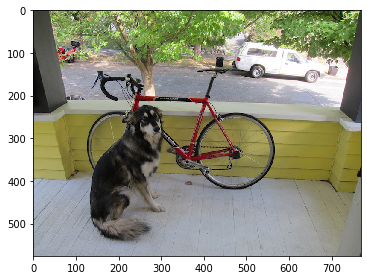

127.0.0.1 - - [05/Jan/2021 10:03:15] "POST /recognition HTTP/1.1" 200 -


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask


app = Flask(__name__)
run_with_ngrok(app)

@app.route('/',methods = ['GET'])
def index():
    return "Hello world !"

@app.route('/recognition', methods=['POST'])
def recognition():
  # On recupere le corps (payload) de la requete qui doit etre une image
  payload = request.form.to_dict()

  # Calcul de ce que contient l'image

  detections = performDetect()['detections']

  result = {}

  for detection in detections :
    if detection[0] in result.keys():
      result[detection[0]] += 1
    else:
      result[detection[0]] = 1

  result = jsonify(result)

  return result
    

if __name__ == '__main__':
  app.run()
